# String Similarity vs Semantic Similarity Analysis

This notebook analyzes the relationship between lexical (string-based) similarity and semantic (embedding-based) 
cosine similarity in biomedical metabolite vector search.

**Core Question**: When vector search succeeds, is it because:
- The query characters look similar to the indexed text (string similarity)?
- The embedding model truly understands the semantic meaning?

**Research Questions**:
1. How correlated are string similarity and cosine similarity for query→result pairs?
2. Do synonym queries (low string sim) achieve high cosine sim? (semantic understanding)
3. Do domain-specific models (SapBERT, BioLORD) show better "semantic gap" than general models?

**Key Metric**: `Semantic Gap = cosine_sim - string_sim`
- Positive gap indicates semantic understanding beyond character matching
- Higher gaps for domain-specific models would indicate better biomedical understanding

## 1. Setup and Configuration

Load required libraries and configure paths to data, embeddings, and indices.

In [2]:
# Core data science stack
import json
from collections import Counter, defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# String similarity (rapidfuzz is faster than python-Levenshtein)
from rapidfuzz import fuzz
from rapidfuzz.distance import Levenshtein

# Vector search
import faiss
from sentence_transformers import SentenceTransformer

# Visualization settings - consistent with other project notebooks
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
# === Configuration ===
# Paths relative to notebooks directory
DATA_DIR = Path('../data/hmdb')
INDICES_DIR = Path('../data/indices/full_synonyms_108')
RESULTS_DIR = Path('../results')

# Models to analyze: 2 domain-specific (biomedical) + 2 general-purpose
# This allows comparison of semantic understanding between model types
MODELS = {
    'minilm': {
        'slug': 'all-minilm-l6-v2',
        'hf_name': 'sentence-transformers/all-MiniLM-L6-v2',
        'type': 'general',
        'dim': 384,
        'description': 'Lightweight general-purpose (current best performer)'
    },
    'bge-m3': {
        'slug': 'bge-m3',
        'hf_name': 'BAAI/bge-m3',
        'type': 'general',
        'dim': 1024,
        'description': 'Multilingual general-purpose baseline'
    },
    'sapbert': {
        'slug': 'sapbert-from-pubmedbert-fulltext',
        'hf_name': 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext',
        'type': 'biomedical',
        'dim': 768,
        'description': 'Biomedical entity linking, trained on UMLS'
    },
    'biolord': {
        'slug': 'biolord-2023',
        'hf_name': 'FremyCompany/BioLORD-2023',
        'type': 'biomedical',
        'dim': 768,
        'description': 'Biomedical with knowledge graph integration'
    }
}

# Query categories from ground truth (for stratified analysis)
QUERY_CATEGORIES = [
    'exact_match',     # Query = primary name (high string sim expected)
    'synonym_match',   # Query = synonym (low string sim, test semantic understanding)
    'fuzzy_match',     # Query with typos (medium string sim)
    'greek_letter',    # α ↔ alpha variations
    'numeric_prefix',  # 3-hydroxy... style queries
    'special_prefix',  # N-acetyl, L-carnitine style
    'arivale'          # Real-world metabolite names from Arivale
]

# Analysis parameters
TOP_K = 10  # Number of results to analyze per query
INDEX_TYPE = 'flat'  # Use flat index for exact similarity scores
STRATEGY = 'multi-vector'  # Production-representative strategy

print(f"Configuration loaded:")
print(f"  Models: {list(MODELS.keys())}")
print(f"  Categories: {len(QUERY_CATEGORIES)}")
print(f"  Index type: {INDEX_TYPE}, Strategy: {STRATEGY}")

Configuration loaded:
  Models: ['minilm', 'bge-m3', 'sapbert', 'biolord']
  Categories: 7
  Index type: flat, Strategy: multi-vector


## 2. Data Loading

Load ground truth queries, metabolite data, and pre-built index metadata.

In [4]:
# Load ground truth queries - these define what we're searching for
with open(DATA_DIR / 'ground_truth.json') as f:
    gt_data = json.load(f)

queries = gt_data['queries']
print(f"Ground truth loaded: {len(queries):,} queries")

# Distribution by category - important for understanding analysis scope
category_counts = Counter(q['category'] for q in queries)
print("\nQueries by category:")
for cat, count in sorted(category_counts.items(), key=lambda x: -x[1]):
    print(f"  {cat}: {count}")

Ground truth loaded: 1,351 queries

Queries by category:
  arivale: 651
  exact_match: 150
  synonym_match: 150
  fuzzy_match: 100
  greek_letter: 100
  numeric_prefix: 100
  special_prefix: 100


In [5]:
# Load metabolite data - needed for computing string similarity to targets
# Structure: {hmdb_id, name, synonyms[]}
with open(DATA_DIR / 'metabolites.json') as f:
    metabolites = json.load(f)

print(f"Metabolites loaded: {len(metabolites):,}")

# Build lookup: hmdb_id -> metabolite dict (for fast access during analysis)
metabolite_lookup = {m['hmdb_id']: m for m in metabolites}

# Sample to verify structure
sample = metabolites[0]
print(f"\nSample metabolite structure:")
print(f"  HMDB ID: {sample['hmdb_id']}")
print(f"  Name: {sample['name']}")
print(f"  Synonyms: {len(sample.get('synonyms', []))} entries")

Metabolites loaded: 217,920

Sample metabolite structure:
  HMDB ID: HMDB0000001
  Name: 1-Methylhistidine
  Synonyms: 15 entries


In [6]:
def load_index_metadata(model_slug: str, strategy: str = 'multi-vector', 
                        index_type: str = 'flat') -> dict:
    """
    Load pre-computed index metadata that maps vector positions to HMDB IDs.
    
    The metadata contains:
    - hmdb_id: Which metabolite this vector represents
    - tier: 'primary', 'synonym', or 'variation'
    - weight: Original weight (1.0, 0.9, 0.7) - we use 1.0 for all in evaluation
    - text: The actual text that was embedded
    
    Args:
        model_slug: Model identifier (e.g., 'all-minilm-l6-v2')
        strategy: Embedding strategy ('single-primary', 'single-pooled', 'multi-vector')
        index_type: FAISS index type ('flat', 'hnsw', etc.)
    
    Returns:
        Dict mapping vector index -> metadata dict
    """
    metadata_path = INDICES_DIR / f"{model_slug}_{strategy}_{index_type}.metadata.json"
    
    if not metadata_path.exists():
        raise FileNotFoundError(f"Metadata not found: {metadata_path}")
    
    with open(metadata_path) as f:
        # Keys are string indices, values are metadata dicts
        metadata = json.load(f)
    
    # Convert string keys to int for faster lookup during search
    return {int(k): v for k, v in metadata.items()}

# Test loading for one model
test_meta = load_index_metadata(MODELS['minilm']['slug'])
print(f"Loaded metadata for minilm: {len(test_meta):,} vectors")
print(f"Sample entry [0]: {test_meta[0]}")

Loaded metadata for minilm: 1,749,141 vectors
Sample entry [0]: {'hmdb_id': 'HMDB0000001', 'tier': 'primary', 'weight': 1.0, 'text': '1-Methylhistidine'}


## 3. Core Similarity Functions

Define functions for computing string similarity and extracting cosine similarity from search results.

In [7]:
@dataclass
class StringSimilarityResult:
    """
    Container for string similarity metrics between query and target text.
    
    We primarily use Levenshtein ratio (0-1) because:
    - It's intuitive: 1.0 = identical, 0.0 = completely different
    - Same scale as cosine similarity, making comparison straightforward
    - Well-suited for metabolite names which vary in length
    """
    levenshtein_ratio: float  # Primary metric: 0-1, higher = more similar
    is_exact_match: bool      # True if strings are identical (case-insensitive)
    query_length: int         # For context in analysis
    target_length: int


def compute_string_similarity(query: str, target: str) -> StringSimilarityResult:
    """
    Compute string similarity between query and target text.
    
    Uses rapidfuzz's Levenshtein ratio which normalizes edit distance
    by the length of the longer string, giving a 0-1 score.
    
    Args:
        query: The search query string
        target: The target text from the index
    
    Returns:
        StringSimilarityResult with computed metrics
    """
    query_lower = query.lower().strip()
    target_lower = target.lower().strip()
    
    # Levenshtein ratio: 100 - normalized_distance * 100, scaled to 0-1
    # fuzz.ratio returns 0-100, we normalize to 0-1 for consistency with cosine
    lev_ratio = fuzz.ratio(query_lower, target_lower) / 100.0
    
    return StringSimilarityResult(
        levenshtein_ratio=lev_ratio,
        is_exact_match=(query_lower == target_lower),
        query_length=len(query),
        target_length=len(target)
    )


def get_best_string_match(query: str, metabolite: dict) -> tuple[str, float]:
    """
    Find the best matching text (primary name or synonym) for a query.
    
    This helps identify whether string similarity is coming from the
    primary name or from a synonym of the metabolite.
    
    Args:
        query: The search query
        metabolite: Dict with 'name' and 'synonyms' keys
    
    Returns:
        Tuple of (best_matching_text, similarity_score)
    """
    best_text = metabolite['name']
    best_sim = compute_string_similarity(query, best_text).levenshtein_ratio
    
    for syn in metabolite.get('synonyms', []):
        sim = compute_string_similarity(query, syn).levenshtein_ratio
        if sim > best_sim:
            best_sim = sim
            best_text = syn
    
    return best_text, best_sim


# Test the functions
test_cases = [
    ("Glucose", "Glucose"),           # Exact match
    ("Glucose", "Glucosamine"),       # Partial overlap
    ("vitamin C", "ascorbic acid"),   # Semantic match, no string similarity
    ("3-hydroxybutyric acid", "3-Hydroxybutyric acid"),  # Case difference
]

print("String similarity test cases:")
print("-" * 60)
for q, t in test_cases:
    result = compute_string_similarity(q, t)
    print(f"'{q}' vs '{t}'")
    print(f"  Levenshtein ratio: {result.levenshtein_ratio:.3f}")
    print(f"  Exact match: {result.is_exact_match}")

String similarity test cases:
------------------------------------------------------------
'Glucose' vs 'Glucose'
  Levenshtein ratio: 1.000
  Exact match: True
'Glucose' vs 'Glucosamine'
  Levenshtein ratio: 0.778
  Exact match: False
'vitamin C' vs 'ascorbic acid'
  Levenshtein ratio: 0.364
  Exact match: False
'3-hydroxybutyric acid' vs '3-Hydroxybutyric acid'
  Levenshtein ratio: 1.000
  Exact match: True


In [8]:
# Cache for loaded models and indices to avoid reloading
_model_cache = {}
_index_cache = {}
_metadata_cache = {}


def load_model(model_name: str) -> SentenceTransformer:
    """Load a SentenceTransformer model with caching."""
    if model_name not in _model_cache:
        hf_name = MODELS[model_name]['hf_name']
        print(f"Loading model: {hf_name}")
        _model_cache[model_name] = SentenceTransformer(hf_name)
    return _model_cache[model_name]


def load_index(model_name: str, strategy: str = 'multi-vector', 
               index_type: str = 'flat') -> tuple[faiss.Index, dict]:
    """
    Load FAISS index and its metadata.
    
    Args:
        model_name: Key from MODELS dict
        strategy: Embedding strategy
        index_type: FAISS index type
    
    Returns:
        Tuple of (FAISS index, metadata dict)
    """
    cache_key = (model_name, strategy, index_type)
    
    if cache_key not in _index_cache:
        model_slug = MODELS[model_name]['slug']
        index_path = INDICES_DIR / f"{model_slug}_{strategy}_{index_type}.faiss"
        
        print(f"Loading index: {index_path.name}")
        index = faiss.read_index(str(index_path))
        metadata = load_index_metadata(model_slug, strategy, index_type)
        
        _index_cache[cache_key] = index
        _metadata_cache[cache_key] = metadata
    
    return _index_cache[cache_key], _metadata_cache[cache_key]


def search_with_scores(model_name: str, query: str, k: int = 10,
                       strategy: str = 'multi-vector',
                       index_type: str = 'flat') -> list[dict]:
    """
    Search index and return results with both cosine and string similarity.
    
    For multi-vector indices, this returns raw results without deduplication
    so we can analyze the actual vector-level similarities.
    
    Args:
        model_name: Key from MODELS dict
        query: Search query string
        k: Number of results to return
        strategy: Embedding strategy
        index_type: FAISS index type
    
    Returns:
        List of dicts with: hmdb_id, cosine_sim, indexed_text, string_sim, tier
    """
    model = load_model(model_name)
    index, metadata = load_index(model_name, strategy, index_type)
    
    # Encode query and normalize for cosine similarity
    query_vec = model.encode([query], convert_to_numpy=True).astype('float32')
    faiss.normalize_L2(query_vec)
    
    # Search - scores are cosine similarities (inner product on normalized vectors)
    scores, indices = index.search(query_vec, k)
    
    results = []
    for score, idx in zip(scores[0], indices[0]):
        if idx < 0:  # FAISS returns -1 for missing results
            continue
        
        meta = metadata[idx]
        indexed_text = meta['text']
        
        # Compute string similarity between query and the indexed text
        string_result = compute_string_similarity(query, indexed_text)
        
        results.append({
            'hmdb_id': meta['hmdb_id'],
            'cosine_sim': float(score),
            'indexed_text': indexed_text,
            'string_sim': string_result.levenshtein_ratio,
            'is_exact_string': string_result.is_exact_match,
            'tier': meta['tier'],
            'rank': len(results)  # 0-indexed rank
        })
    
    return results


# Test search on one query
print("Testing search function...")
test_query = queries[0]['query']
test_results = search_with_scores('minilm', test_query, k=5)

print(f"\nQuery: '{test_query}'")
print(f"Expected: {queries[0]['expected']}")
print("\nTop 5 results:")
for r in test_results:
    print(f"  Rank {r['rank']}: {r['hmdb_id']} (cosine={r['cosine_sim']:.3f}, string={r['string_sim']:.3f})")
    print(f"    Text: '{r['indexed_text'][:50]}...' [{r['tier']}]")

Testing search function...
Loading model: sentence-transformers/all-MiniLM-L6-v2
Loading index: all-minilm-l6-v2_multi-vector_flat.faiss

Query: 'Indalpine'
Expected: ['HMDB0253446']

Top 5 results:
  Rank 0: HMDB0253446 (cosine=1.000, string=1.000)
    Text: 'Indalpine...' [primary]
  Rank 1: HMDB0014552 (cosine=0.699, string=0.588)
    Text: 'Loxapine...' [primary]
  Rank 2: HMDB0244884 (cosine=0.685, string=0.706)
    Text: 'Indazole...' [primary]
  Rank 3: HMDB0256346 (cosine=0.675, string=0.556)
    Text: 'Perlapine...' [primary]
  Rank 4: HMDB0244479 (cosine=0.663, string=0.667)
    Text: 'indanamin...' [synonym]


## 4. Build Analysis DataFrame

For each ground truth query, run searches across all models and collect similarity metrics.
This creates our main analysis dataset.

In [9]:
def build_analysis_dataframe(models_to_analyze: list[str], 
                             queries_subset: list[dict] = None,
                             k: int = 10) -> pd.DataFrame:
    """
    Build comprehensive dataframe with string and cosine similarities for all query-result pairs.
    
    For each query:
    1. Run search on each model
    2. For each result, compute string similarity to query
    3. Also compute string similarity to the BEST match in the expected metabolite
    4. Record whether retrieval succeeded (correct HMDB ID in results)
    
    Args:
        models_to_analyze: List of model names from MODELS dict
        queries_subset: Optional subset of queries (uses all if None)
        k: Number of results per query
    
    Returns:
        DataFrame with columns:
        - query, category, expected_id, model, model_type
        - rank, result_hmdb_id, cosine_sim, string_sim
        - tier, is_correct, is_exact_string
        - best_possible_string_sim (to expected metabolite)
        - semantic_gap (cosine - string)
    """
    if queries_subset is None:
        queries_subset = queries
    
    records = []
    total_searches = len(queries_subset) * len(models_to_analyze)
    completed = 0
    
    print(f"Building analysis dataframe...")
    print(f"  Queries: {len(queries_subset):,}")
    print(f"  Models: {models_to_analyze}")
    print(f"  Total searches: {total_searches:,}")
    
    for model_name in models_to_analyze:
        model_info = MODELS[model_name]
        print(f"\n  Processing {model_name}...")
        
        for i, q in enumerate(queries_subset):
            query_text = q['query']
            expected_ids = set(q['expected'])
            category = q['category']
            
            # Compute best possible string similarity to expected metabolite(s)
            best_possible_string = 0.0
            for exp_id in expected_ids:
                if exp_id in metabolite_lookup:
                    _, sim = get_best_string_match(query_text, metabolite_lookup[exp_id])
                    best_possible_string = max(best_possible_string, sim)
            
            # Search and collect results
            try:
                results = search_with_scores(model_name, query_text, k=k)
            except Exception as e:
                print(f"    Error on query '{query_text[:30]}...': {e}")
                continue
            
            for r in results:
                is_correct = r['hmdb_id'] in expected_ids
                semantic_gap = r['cosine_sim'] - r['string_sim']
                
                records.append({
                    'query': query_text,
                    'category': category,
                    'expected_id': list(expected_ids)[0],  # Primary expected
                    'model': model_name,
                    'model_type': model_info['type'],
                    'rank': r['rank'],
                    'result_hmdb_id': r['hmdb_id'],
                    'cosine_sim': r['cosine_sim'],
                    'string_sim': r['string_sim'],
                    'tier': r['tier'],
                    'is_correct': is_correct,
                    'is_exact_string': r['is_exact_string'],
                    'indexed_text': r['indexed_text'],
                    'best_possible_string_sim': best_possible_string,
                    'semantic_gap': semantic_gap
                })
            
            completed += 1
            if (i + 1) % 200 == 0:
                print(f"    Processed {i + 1}/{len(queries_subset)} queries")
    
    df = pd.DataFrame(records)
    print(f"\nDataframe built: {len(df):,} rows")
    return df


# Build the main analysis dataframe
# Note: This may take a few minutes as it loads models and runs searches
analysis_df = build_analysis_dataframe(
    models_to_analyze=list(MODELS.keys()),
    k=TOP_K
)

print(f"\nDataframe shape: {analysis_df.shape}")
print(f"Columns: {list(analysis_df.columns)}")

Building analysis dataframe...
  Queries: 1,351
  Models: ['minilm', 'bge-m3', 'sapbert', 'biolord']
  Total searches: 5,404

  Processing minilm...
    Processed 200/1351 queries
    Processed 400/1351 queries
    Processed 600/1351 queries
    Processed 800/1351 queries
    Processed 1000/1351 queries
    Processed 1200/1351 queries

  Processing bge-m3...
Loading model: BAAI/bge-m3
Loading index: bge-m3_multi-vector_flat.faiss
    Processed 200/1351 queries
    Processed 400/1351 queries
    Processed 600/1351 queries
    Processed 800/1351 queries
    Processed 1000/1351 queries
    Processed 1200/1351 queries

  Processing sapbert...
Loading model: cambridgeltl/SapBERT-from-PubMedBERT-fulltext


No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext. Creating a new one with mean pooling.


Loading index: sapbert-from-pubmedbert-fulltext_multi-vector_flat.faiss
    Processed 200/1351 queries
    Processed 400/1351 queries
    Processed 600/1351 queries
    Processed 800/1351 queries
    Processed 1000/1351 queries
    Processed 1200/1351 queries

  Processing biolord...
Loading model: FremyCompany/BioLORD-2023
Loading index: biolord-2023_multi-vector_flat.faiss
    Processed 200/1351 queries
    Processed 400/1351 queries
    Processed 600/1351 queries
    Processed 800/1351 queries
    Processed 1000/1351 queries
    Processed 1200/1351 queries

Dataframe built: 54,040 rows

Dataframe shape: (54040, 15)
Columns: ['query', 'category', 'expected_id', 'model', 'model_type', 'rank', 'result_hmdb_id', 'cosine_sim', 'string_sim', 'tier', 'is_correct', 'is_exact_string', 'indexed_text', 'best_possible_string_sim', 'semantic_gap']


In [10]:
# Quick summary of the analysis dataframe
print("Analysis DataFrame Summary")
print("=" * 50)
print(f"Total rows: {len(analysis_df):,}")
print(f"Unique queries: {analysis_df['query'].nunique():,}")
print(f"Models: {analysis_df['model'].unique().tolist()}")

print("\nRows by model type:")
print(analysis_df.groupby('model_type').size())

print("\nRows by category:")
print(analysis_df.groupby('category').size().sort_values(ascending=False))

print("\nCorrect retrievals (rank 0):")
rank0 = analysis_df[analysis_df['rank'] == 0]
print(rank0.groupby('model')['is_correct'].mean().round(3))

Analysis DataFrame Summary
Total rows: 54,040
Unique queries: 1,350
Models: ['minilm', 'bge-m3', 'sapbert', 'biolord']

Rows by model type:
model_type
biomedical    27020
general       27020
dtype: int64

Rows by category:
category
arivale           26040
exact_match        6000
synonym_match      6000
fuzzy_match        4000
greek_letter       4000
numeric_prefix     4000
special_prefix     4000
dtype: int64

Correct retrievals (rank 0):
model
bge-m3     0.754
biolord    0.765
minilm     0.782
sapbert    0.764
Name: is_correct, dtype: float64


## 5. Correlation Analysis

Analyze how string similarity correlates with cosine similarity.

**Key question**: When cosine similarity is high, is it because strings are similar (lexical matching)
or despite strings being different (semantic understanding)?

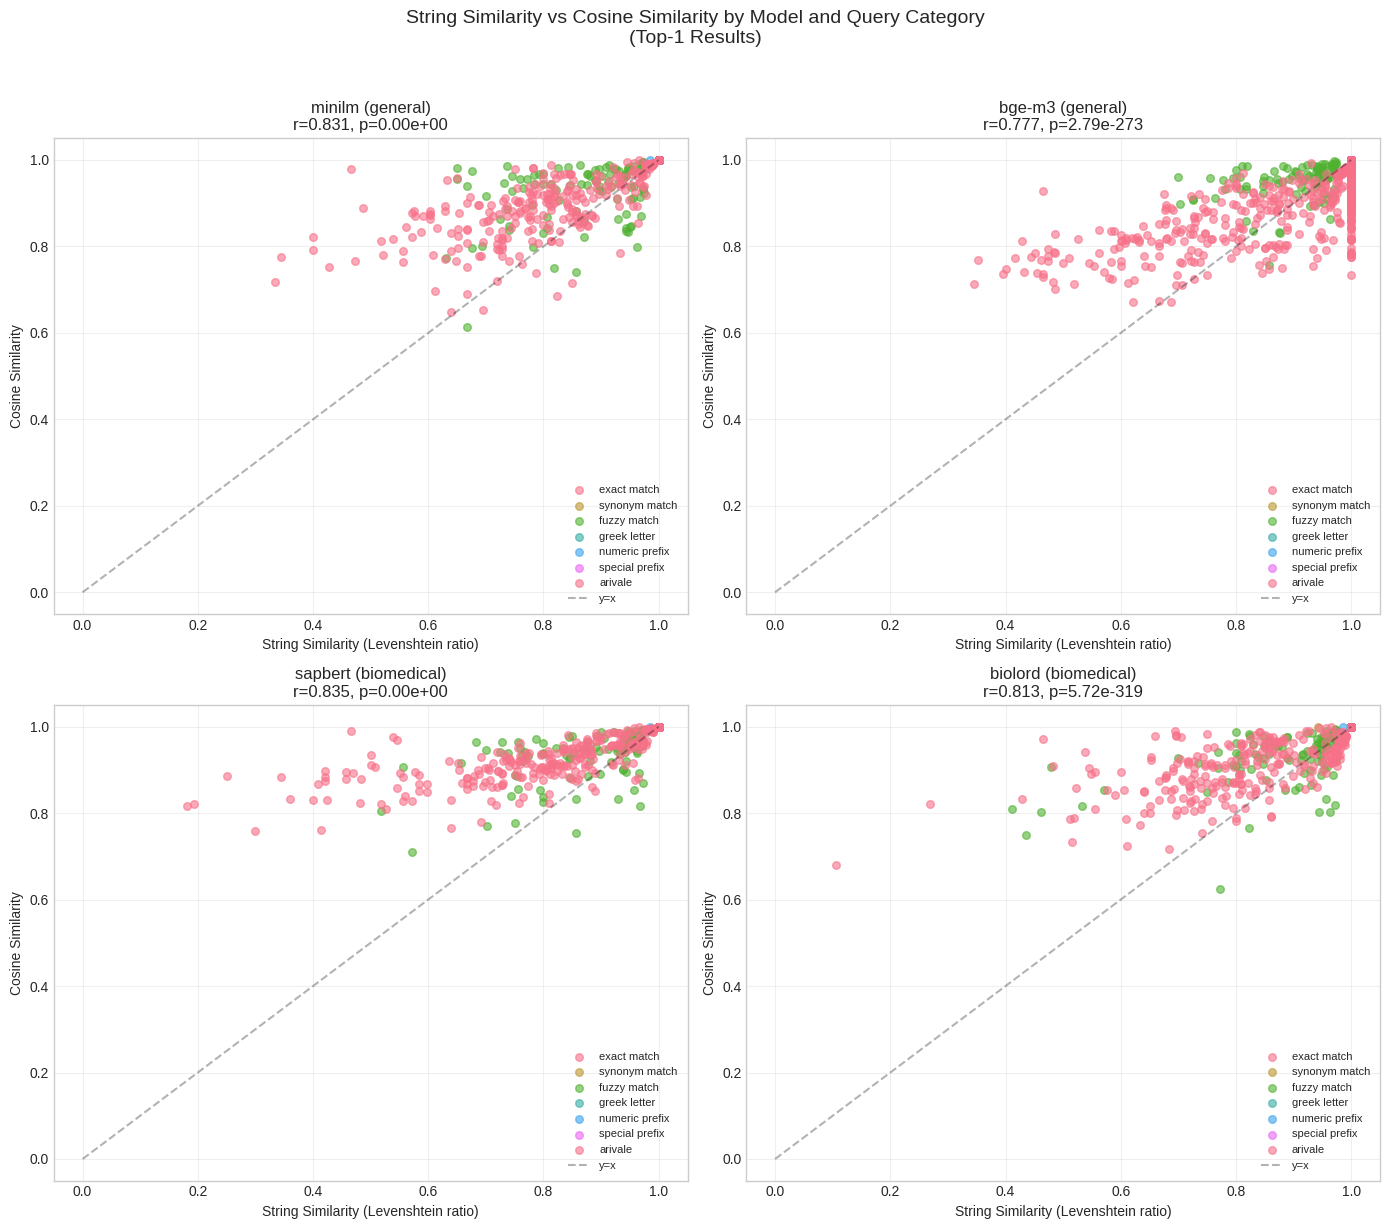

In [11]:
# Scatter plot: String similarity vs Cosine similarity
# Color by category to see how different query types behave

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# One plot per model
for idx, model_name in enumerate(MODELS.keys()):
    ax = axes[idx // 2, idx % 2]
    model_df = analysis_df[analysis_df['model'] == model_name]
    
    # Use rank 0 results only for cleaner visualization
    rank0 = model_df[model_df['rank'] == 0]
    
    # Scatter with category coloring
    for cat in QUERY_CATEGORIES:
        cat_data = rank0[rank0['category'] == cat]
        if len(cat_data) > 0:
            ax.scatter(
                cat_data['string_sim'], 
                cat_data['cosine_sim'],
                label=cat.replace('_', ' '),
                alpha=0.6,
                s=30
            )
    
    # Add diagonal reference line (string_sim = cosine_sim)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
    
    # Compute overall correlation
    r, p = stats.pearsonr(rank0['string_sim'], rank0['cosine_sim'])
    
    ax.set_xlabel('String Similarity (Levenshtein ratio)')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f"{model_name} ({MODELS[model_name]['type']})\nr={r:.3f}, p={p:.2e}")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('String Similarity vs Cosine Similarity by Model and Query Category\n(Top-1 Results)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Key insight:
# Points ABOVE the diagonal = semantic understanding (high cosine despite low string sim)
# Points ON the diagonal = lexical matching (cosine tracks string sim)
# Points BELOW the diagonal = rare, would indicate string match but semantic mismatch

In [12]:
# Compute correlations by category and model
# This shows which categories rely more on string vs semantic matching

correlation_results = []

for model_name in MODELS.keys():
    model_df = analysis_df[(analysis_df['model'] == model_name) & (analysis_df['rank'] == 0)]
    
    for cat in QUERY_CATEGORIES:
        cat_df = model_df[model_df['category'] == cat]
        if len(cat_df) >= 5:  # Need enough data points
            r, p = stats.pearsonr(cat_df['string_sim'], cat_df['cosine_sim'])
            correlation_results.append({
                'model': model_name,
                'model_type': MODELS[model_name]['type'],
                'category': cat,
                'n_queries': len(cat_df),
                'pearson_r': r,
                'p_value': p,
                'mean_string_sim': cat_df['string_sim'].mean(),
                'mean_cosine_sim': cat_df['cosine_sim'].mean(),
                'mean_semantic_gap': cat_df['semantic_gap'].mean()
            })

corr_df = pd.DataFrame(correlation_results)

print("Correlation Analysis: String Similarity vs Cosine Similarity")
print("=" * 70)
print("\nInterpretation:")
print("  r ≈ 1: Cosine sim tracks string sim (lexical matching dominates)")
print("  r ≈ 0: Cosine sim independent of string sim (semantic understanding)")
print("  Positive semantic_gap: Model finds semantic matches despite string differences")

# Show pivot table: categories x models
pivot_r = corr_df.pivot(index='category', columns='model', values='pearson_r')
print("\nPearson r by Category and Model:")
print(pivot_r.round(3))

Correlation Analysis: String Similarity vs Cosine Similarity

Interpretation:
  r ≈ 1: Cosine sim tracks string sim (lexical matching dominates)
  r ≈ 0: Cosine sim independent of string sim (semantic understanding)
  Positive semantic_gap: Model finds semantic matches despite string differences

Pearson r by Category and Model:
model           bge-m3  biolord  minilm  sapbert
category                                        
arivale          0.754    0.815   0.846    0.857
exact_match        NaN      NaN     NaN      NaN
fuzzy_match      0.310    0.484   0.314    0.464
greek_letter       NaN      NaN     NaN      NaN
numeric_prefix     NaN   -0.140  -0.138   -0.115
special_prefix     NaN      NaN     NaN      NaN
synonym_match      NaN   -0.134     NaN      NaN


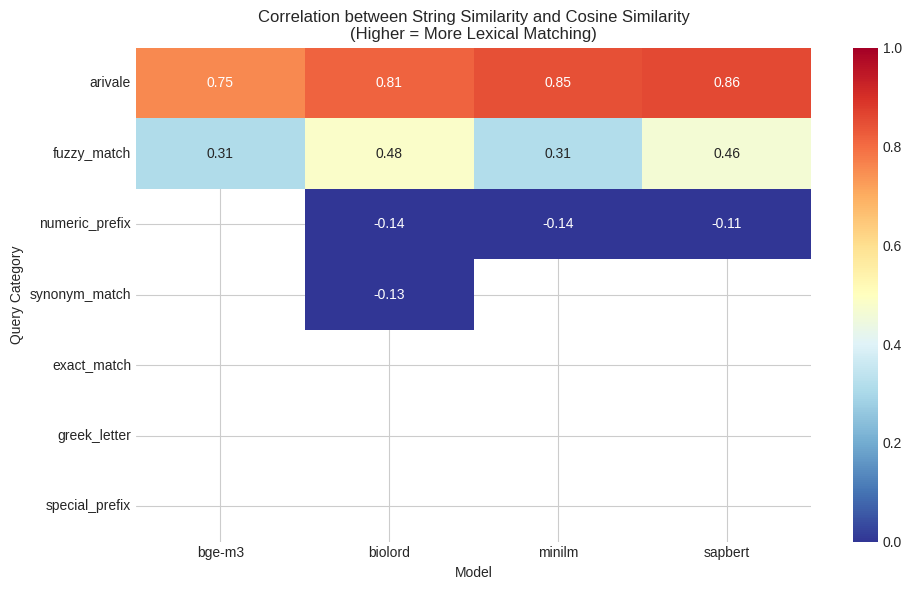


HOW TO READ THIS HEATMAP

WHAT IT MEASURES: Pearson correlation (r) between string similarity and cosine similarity

INTERPRETATION:
  r ≈ 1.0 (RED)   → Cosine sim tracks string sim closely
                    = Model relies on CHARACTER OVERLAP to find matches
                    = "Lexical matching" dominates

  r ≈ 0.5 (WHITE) → Moderate relationship
                    = Mix of lexical and semantic matching

  r ≈ 0.0 (BLUE)  → Cosine sim is INDEPENDENT of string sim
                    = Model finds matches despite different characters
                    = "Semantic understanding" dominates

  r < 0 (DEEP BLUE) → INVERSE relationship (rare)
                    = High cosine when strings are very different

KEY INSIGHT: Categories showing LOW correlation (blue) are where models 
             demonstrate true semantic understanding beyond character matching.


OBSERVATIONS FROM THIS DATA:
--------------------------------------------------
HIGH correlation categories (model uses st

In [13]:
# Heatmap of correlations
fig, ax = plt.subplots(figsize=(10, 6))

pivot_r = corr_df.pivot(index='category', columns='model', values='pearson_r')

# Reorder by mean correlation (highest correlation = most string-dependent at top)
row_order = pivot_r.mean(axis=1).sort_values(ascending=False).index
pivot_r = pivot_r.loc[row_order]

sns.heatmap(pivot_r, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0.5, vmin=0, vmax=1, ax=ax)

ax.set_title('Correlation between String Similarity and Cosine Similarity\n(Higher = More Lexical Matching)')
ax.set_xlabel('Model')
ax.set_ylabel('Query Category')

plt.tight_layout()
plt.show()

# Clear interpretation
print("\n" + "=" * 70)
print("HOW TO READ THIS HEATMAP")
print("=" * 70)
print("""
WHAT IT MEASURES: Pearson correlation (r) between string similarity and cosine similarity

INTERPRETATION:
  r ≈ 1.0 (RED)   → Cosine sim tracks string sim closely
                    = Model relies on CHARACTER OVERLAP to find matches
                    = "Lexical matching" dominates
                    
  r ≈ 0.5 (WHITE) → Moderate relationship
                    = Mix of lexical and semantic matching
                    
  r ≈ 0.0 (BLUE)  → Cosine sim is INDEPENDENT of string sim
                    = Model finds matches despite different characters
                    = "Semantic understanding" dominates
                    
  r < 0 (DEEP BLUE) → INVERSE relationship (rare)
                    = High cosine when strings are very different

KEY INSIGHT: Categories showing LOW correlation (blue) are where models 
             demonstrate true semantic understanding beyond character matching.
""")

# Interpretation help
print("\nOBSERVATIONS FROM THIS DATA:")
print("-" * 50)
print("HIGH correlation categories (model uses string matching):")
high_corr = corr_df[corr_df['pearson_r'] > 0.7].groupby('category')['pearson_r'].mean().sort_values(ascending=False)
for cat, r in high_corr.items():
    print(f"  {cat}: r={r:.3f}")

print("\nLOW correlation categories (model uses semantic understanding):")
low_corr = corr_df[corr_df['pearson_r'] < 0.3].groupby('category')['pearson_r'].mean().sort_values()
for cat, r in low_corr.items():
    print(f"  {cat}: r={r:.3f}")

## 6. Category Breakdown

Analyze how similarity metrics differ by query type.

**Expected patterns**:
- `exact_match`: High string sim, high cosine sim, low semantic gap
- `synonym_match`: Low string sim (different spelling), high cosine sim if model understands synonyms
- `fuzzy_match`: Medium string sim (typos), test model robustness
- `greek_letter`: α vs alpha - should show semantic understanding

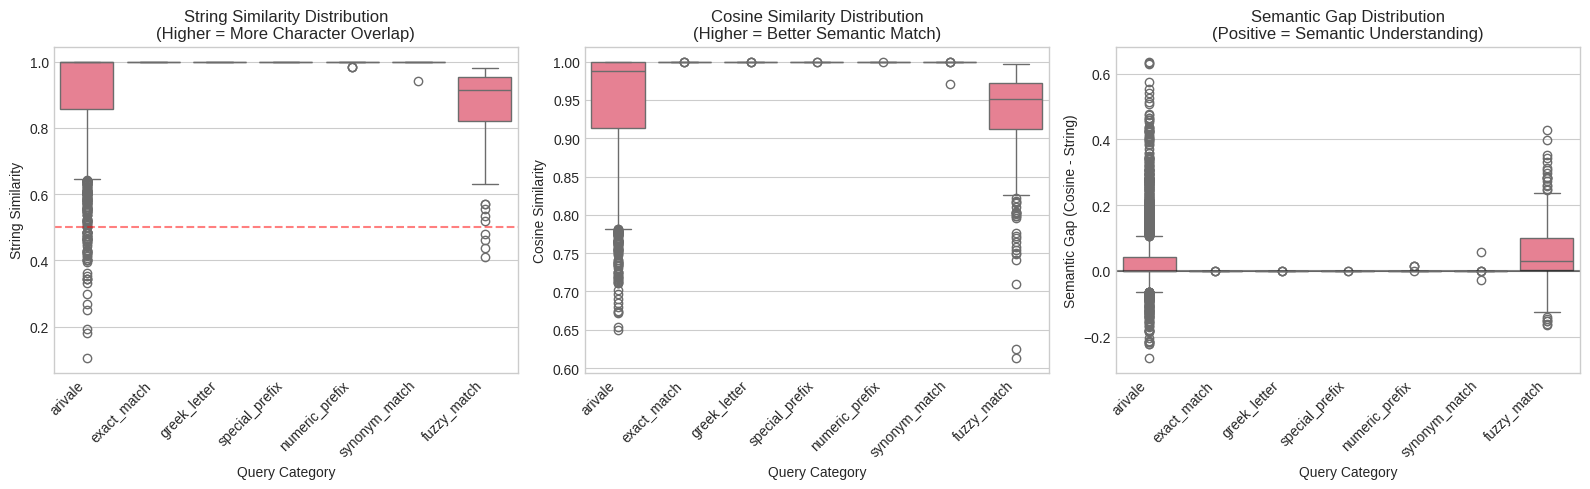


Category Summary (Top-1 Results):
                string_sim_mean  string_sim_std  cosine_sim_mean  cosine_sim_std  semantic_gap_mean  semantic_gap_std  is_correct_mean
category                                                                                                                              
arivale                   0.916           0.139            0.949           0.070              0.033             0.096            0.646
exact_match               1.000           0.000            1.000           0.000              0.000             0.000            0.985
fuzzy_match               0.878           0.100            0.932           0.059              0.053             0.092            0.442
greek_letter              1.000           0.000            1.000           0.000              0.000             0.000            0.992
numeric_prefix            1.000           0.001            1.000           0.000              0.000             0.001            0.998
special_prefix      

In [14]:
# Box plots comparing string and cosine similarity by category
# Focus on top-1 results to compare retrieval quality

rank0_df = analysis_df[analysis_df['rank'] == 0].copy()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: String Similarity by Category
ax = axes[0]
category_order = rank0_df.groupby('category')['string_sim'].median().sort_values(ascending=False).index
sns.boxplot(data=rank0_df, x='category', y='string_sim', order=category_order, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Query Category')
ax.set_ylabel('String Similarity')
ax.set_title('String Similarity Distribution\n(Higher = More Character Overlap)')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')

# Plot 2: Cosine Similarity by Category
ax = axes[1]
sns.boxplot(data=rank0_df, x='category', y='cosine_sim', order=category_order, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Query Category')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Cosine Similarity Distribution\n(Higher = Better Semantic Match)')

# Plot 3: Semantic Gap by Category (the key insight)
ax = axes[2]
sns.boxplot(data=rank0_df, x='category', y='semantic_gap', order=category_order, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Query Category')
ax.set_ylabel('Semantic Gap (Cosine - String)')
ax.set_title('Semantic Gap Distribution\n(Positive = Semantic Understanding)')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nCategory Summary (Top-1 Results):")
print("=" * 80)
summary = rank0_df.groupby('category').agg({
    'string_sim': ['mean', 'std'],
    'cosine_sim': ['mean', 'std'],
    'semantic_gap': ['mean', 'std'],
    'is_correct': 'mean'  # Recall@1
}).round(3)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
print(summary.to_string())

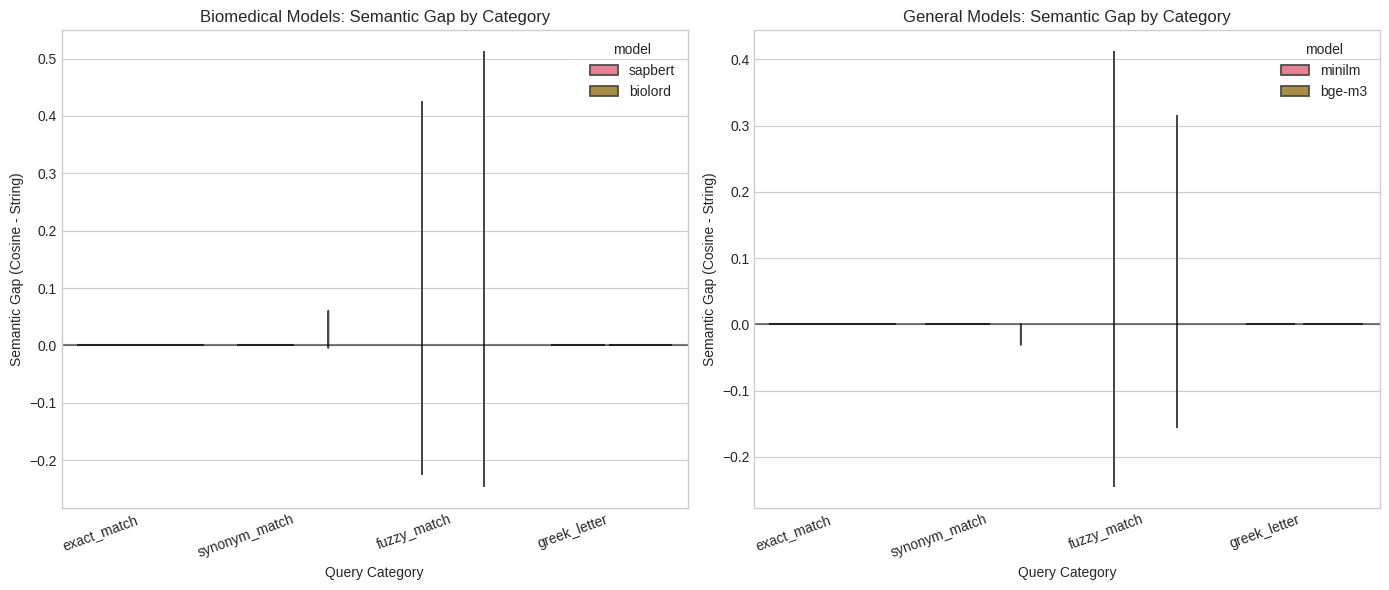

In [15]:
# Violin plots showing distribution shapes for semantic gap
# Split by model type to compare biomedical vs general

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Categories of interest for semantic analysis
key_categories = ['exact_match', 'synonym_match', 'fuzzy_match', 'greek_letter']
filtered_df = rank0_df[rank0_df['category'].isin(key_categories)]

# Left: Biomedical models
ax = axes[0]
bio_df = filtered_df[filtered_df['model_type'] == 'biomedical']
sns.violinplot(data=bio_df, x='category', y='semantic_gap', hue='model', 
               order=key_categories, ax=ax, inner='quartile')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_title('Biomedical Models: Semantic Gap by Category')
ax.set_xlabel('Query Category')
ax.set_ylabel('Semantic Gap (Cosine - String)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

# Right: General models
ax = axes[1]
gen_df = filtered_df[filtered_df['model_type'] == 'general']
sns.violinplot(data=gen_df, x='category', y='semantic_gap', hue='model', 
               order=key_categories, ax=ax, inner='quartile')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_title('General Models: Semantic Gap by Category')
ax.set_xlabel('Query Category')
ax.set_ylabel('Semantic Gap (Cosine - String)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

plt.tight_layout()
plt.show()

## 7. Model Comparison: Domain-Specific vs General

Compare whether biomedical models (SapBERT, BioLORD) show better "semantic understanding"
than general models (MiniLM, BGE-M3).

**Hypothesis**: Domain-specific models should show larger semantic gaps for synonym queries
(high cosine when string is low), indicating they understand biomedical term equivalence.

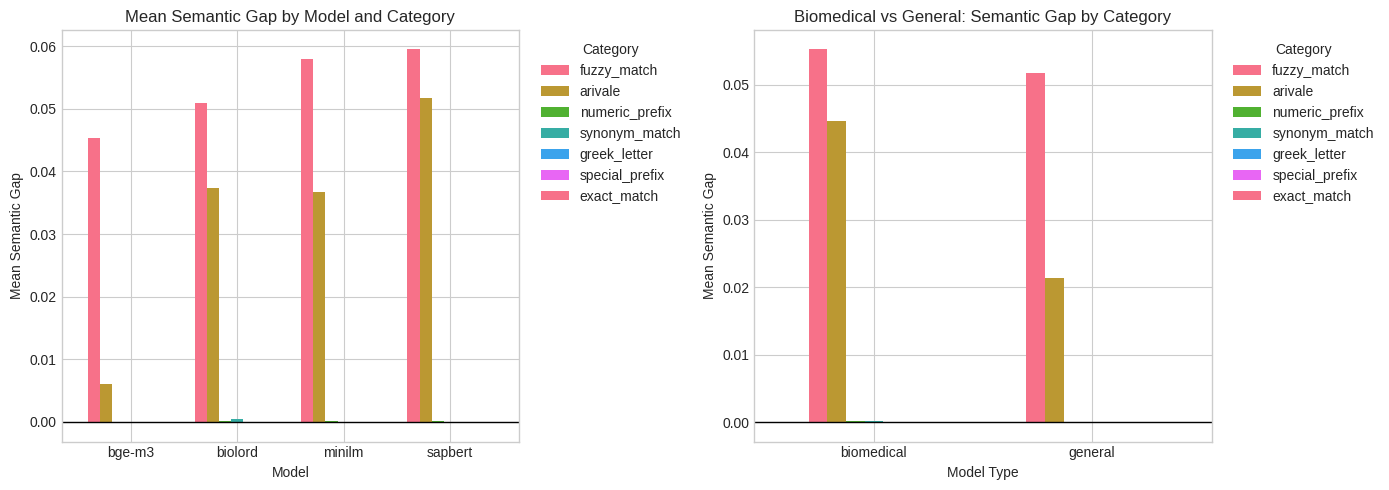

In [16]:
# Semantic gap comparison: Biomedical vs General models

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean semantic gap by model and category
ax = axes[0]
gap_means = rank0_df.groupby(['model', 'category'])['semantic_gap'].mean().unstack()

# Reorder columns by overall gap
col_order = gap_means.mean().sort_values(ascending=False).index
gap_means = gap_means[col_order]

gap_means.plot(kind='bar', ax=ax, width=0.8)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Model')
ax.set_ylabel('Mean Semantic Gap')
ax.set_title('Mean Semantic Gap by Model and Category')
ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Right: Overall model type comparison
ax = axes[1]
type_comparison = rank0_df.groupby(['model_type', 'category'])['semantic_gap'].mean().unstack()
type_comparison = type_comparison[col_order]

type_comparison.plot(kind='bar', ax=ax, width=0.6)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Model Type')
ax.set_ylabel('Mean Semantic Gap')
ax.set_title('Biomedical vs General: Semantic Gap by Category')
ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

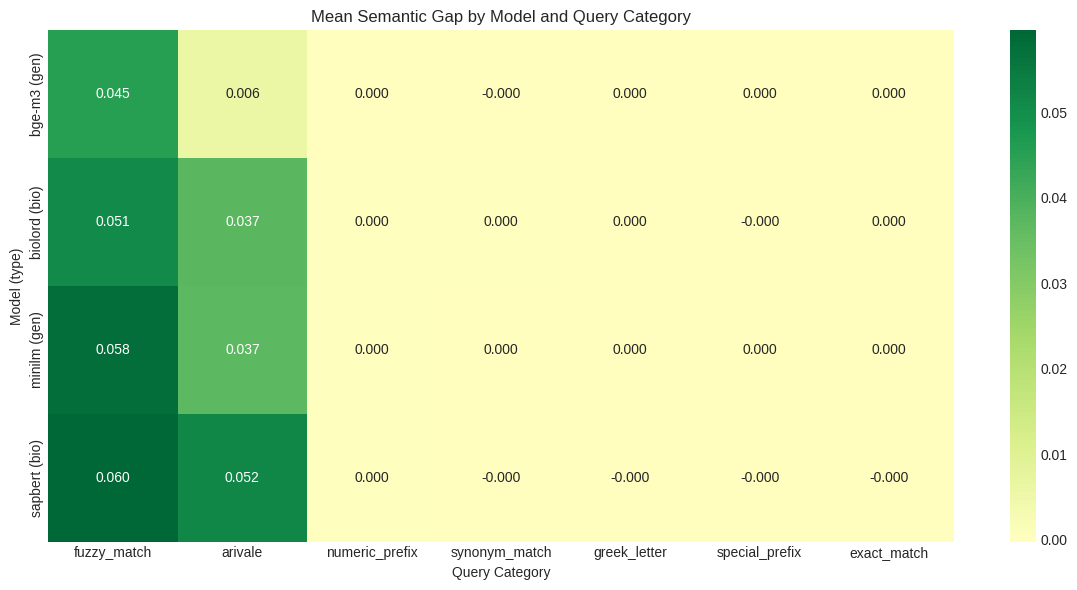


HOW TO READ THIS HEATMAP

WHAT IT MEASURES: Semantic Gap = Cosine Similarity - String Similarity

WHERE:
  - String Similarity: Levenshtein ratio (0-1), measures CHARACTER OVERLAP
    e.g., "glucose" vs "glucosamine" = 0.78 (many shared characters)

  - Cosine Similarity: Embedding vector similarity (0-1), measures MEANING
    e.g., "vitamin C" vs "ascorbic acid" = high (same molecule, different names)

INTERPRETATION:
  GREEN (Positive gap)  → Cosine > String
                         = Model finds matches despite DIFFERENT characters
                         = "Semantic understanding" - model knows meaning

  WHITE (Near zero)     → Cosine ≈ String
                         = Semantic similarity tracks character overlap
                         = Hard to distinguish lexical from semantic matching

  RED (Negative gap)    → Cosine < String
                         = High string overlap but model doesn't think it's a match
                         = Rare case indicating model-specific b

In [17]:
# Heatmap: Semantic gap by model × category

fig, ax = plt.subplots(figsize=(12, 6))

gap_pivot = rank0_df.groupby(['model', 'category'])['semantic_gap'].mean().unstack()

# Sort categories by overall gap
col_order = gap_pivot.mean().sort_values(ascending=False).index
gap_pivot = gap_pivot[col_order]

# Add model type annotation
model_labels = [f"{m} ({MODELS[m]['type'][:3]})" for m in gap_pivot.index]

sns.heatmap(gap_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, ax=ax, yticklabels=model_labels)

ax.set_title('Mean Semantic Gap by Model and Query Category')
ax.set_xlabel('Query Category')
ax.set_ylabel('Model (type)')

plt.tight_layout()
plt.show()

# Clear interpretation guide
print("\n" + "=" * 70)
print("HOW TO READ THIS HEATMAP")
print("=" * 70)
print("""
WHAT IT MEASURES: Semantic Gap = Cosine Similarity - String Similarity

WHERE:
  - String Similarity: Levenshtein ratio (0-1), measures CHARACTER OVERLAP
    e.g., "glucose" vs "glucosamine" = 0.78 (many shared characters)

  - Cosine Similarity: Embedding vector similarity (0-1), measures MEANING
    e.g., "vitamin C" vs "ascorbic acid" = high (same molecule, different names)

INTERPRETATION:
  GREEN (Positive gap)  → Cosine > String
                         = Model finds matches despite DIFFERENT characters
                         = "Semantic understanding" - model knows meaning

  WHITE (Near zero)     → Cosine ≈ String
                         = Semantic similarity tracks character overlap
                         = Hard to distinguish lexical from semantic matching

  RED (Negative gap)    → Cosine < String
                         = High string overlap but model doesn't think it's a match
                         = Rare case indicating model-specific behavior

KEY INSIGHT: Categories showing GREEN (positive gaps) are where models
             demonstrate semantic understanding beyond character matching.
             Biomedical models should show more green in synonym/greek_letter
             categories if they truly understand biomedical term equivalence.
""")

# Statistical test: Biomedical vs General
print("\nStatistical Test: Biomedical vs General Models")
print("=" * 50)

bio_gaps = rank0_df[rank0_df['model_type'] == 'biomedical']['semantic_gap']
gen_gaps = rank0_df[rank0_df['model_type'] == 'general']['semantic_gap']

print(f"Biomedical mean gap: {bio_gaps.mean():.4f} (std: {bio_gaps.std():.4f})")
print(f"General mean gap: {gen_gaps.mean():.4f} (std: {gen_gaps.std():.4f})")

# Mann-Whitney U test (non-parametric)
stat, p = stats.mannwhitneyu(bio_gaps, gen_gaps, alternative='two-sided')
print(f"\nMann-Whitney U test: U={stat:.0f}, p={p:.4e}")
if p < 0.05:
    print("Result: Significant difference between model types")
else:
    print("Result: No significant difference between model types")

Synonym Query Analysis: The Semantic Understanding Test

These queries search using a synonym (different spelling).
Success requires semantic understanding, not string matching.

         Mean String Sim  Mean Cosine Sim  Mean Semantic Gap  Recall@1        Type
model                                                                             
bge-m3            1.0000           0.9998            -0.0002    0.8400     general
biolord           0.9996           1.0000             0.0004    0.8267  biomedical
minilm            1.0000           1.0000             0.0000    0.8333     general
sapbert           1.0000           1.0000            -0.0000    0.8400  biomedical


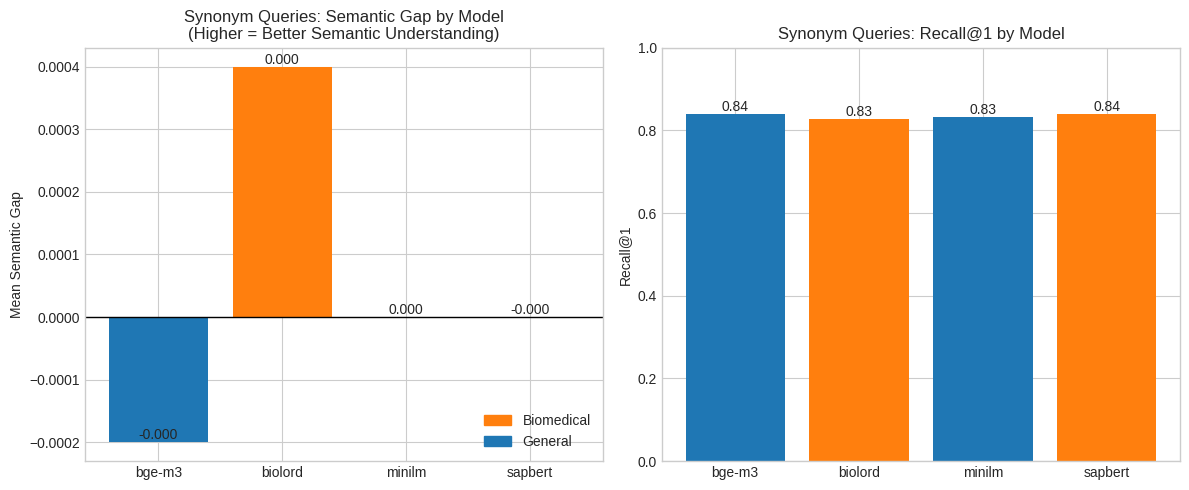

In [18]:
# Deep dive: Synonym queries - the key test of semantic understanding
# These queries have intentionally low string similarity (different spelling)
# Success requires the model to understand that synonyms are equivalent

synonym_df = rank0_df[rank0_df['category'] == 'synonym_match'].copy()

print("Synonym Query Analysis: The Semantic Understanding Test")
print("=" * 60)
print("\nThese queries search using a synonym (different spelling).")
print("Success requires semantic understanding, not string matching.")
print()

# Compare models on synonym queries
synonym_stats = synonym_df.groupby('model').agg({
    'string_sim': 'mean',
    'cosine_sim': 'mean',
    'semantic_gap': 'mean',
    'is_correct': 'mean'  # Recall@1
}).round(4)

synonym_stats = synonym_stats.rename(columns={
    'string_sim': 'Mean String Sim',
    'cosine_sim': 'Mean Cosine Sim',
    'semantic_gap': 'Mean Semantic Gap',
    'is_correct': 'Recall@1'
})

# Add model type
synonym_stats['Type'] = [MODELS[m]['type'] for m in synonym_stats.index]

print(synonym_stats.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Semantic gap comparison
ax = axes[0]
colors = ['#ff7f0e' if MODELS[m]['type'] == 'biomedical' else '#1f77b4' 
          for m in synonym_stats.index]
bars = ax.bar(synonym_stats.index, synonym_stats['Mean Semantic Gap'], color=colors)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Mean Semantic Gap')
ax.set_title('Synonym Queries: Semantic Gap by Model\n(Higher = Better Semantic Understanding)')
ax.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#ff7f0e', label='Biomedical'),
    plt.Rectangle((0,0),1,1, color='#1f77b4', label='General')
], loc='lower right')

# Add value labels
for bar, val in zip(bars, synonym_stats['Mean Semantic Gap']):
    ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

# Right: Recall@1 comparison
ax = axes[1]
bars = ax.bar(synonym_stats.index, synonym_stats['Recall@1'], color=colors)
ax.set_ylabel('Recall@1')
ax.set_title('Synonym Queries: Recall@1 by Model')
ax.set_ylim(0, 1)

for bar, val in zip(bars, synonym_stats['Recall@1']):
    ax.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Success Analysis

Analyze when retrieval succeeds vs fails and what predicts success.

Success: 4,140 queries, Failure: 1,264 queries


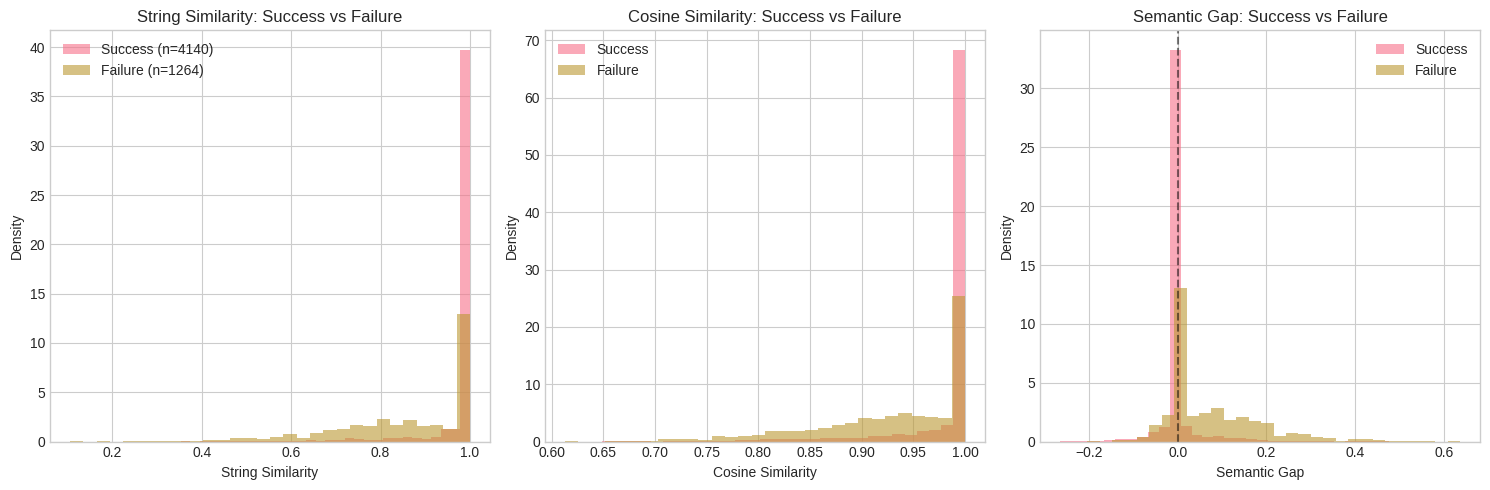


Mean Similarities for Success vs Failure:
  Success: string=0.979, cosine=0.983, gap=0.004
  Failure: string=0.857, cosine=0.930, gap=0.073


In [19]:
# Compare similarity distributions for successful vs failed retrievals

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use top-1 results
success_df = rank0_df[rank0_df['is_correct'] == True]
failure_df = rank0_df[rank0_df['is_correct'] == False]

print(f"Success: {len(success_df):,} queries, Failure: {len(failure_df):,} queries")

# Plot 1: String similarity distribution
ax = axes[0]
ax.hist(success_df['string_sim'], bins=30, alpha=0.6, label=f'Success (n={len(success_df)})', density=True)
ax.hist(failure_df['string_sim'], bins=30, alpha=0.6, label=f'Failure (n={len(failure_df)})', density=True)
ax.set_xlabel('String Similarity')
ax.set_ylabel('Density')
ax.set_title('String Similarity: Success vs Failure')
ax.legend()

# Plot 2: Cosine similarity distribution
ax = axes[1]
ax.hist(success_df['cosine_sim'], bins=30, alpha=0.6, label=f'Success', density=True)
ax.hist(failure_df['cosine_sim'], bins=30, alpha=0.6, label=f'Failure', density=True)
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title('Cosine Similarity: Success vs Failure')
ax.legend()

# Plot 3: Semantic gap distribution
ax = axes[2]
ax.hist(success_df['semantic_gap'], bins=30, alpha=0.6, label=f'Success', density=True)
ax.hist(failure_df['semantic_gap'], bins=30, alpha=0.6, label=f'Failure', density=True)
ax.set_xlabel('Semantic Gap')
ax.set_ylabel('Density')
ax.set_title('Semantic Gap: Success vs Failure')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nMean Similarities for Success vs Failure:")
print(f"  Success: string={success_df['string_sim'].mean():.3f}, cosine={success_df['cosine_sim'].mean():.3f}, gap={success_df['semantic_gap'].mean():.3f}")
print(f"  Failure: string={failure_df['string_sim'].mean():.3f}, cosine={failure_df['cosine_sim'].mean():.3f}, gap={failure_df['semantic_gap'].mean():.3f}")

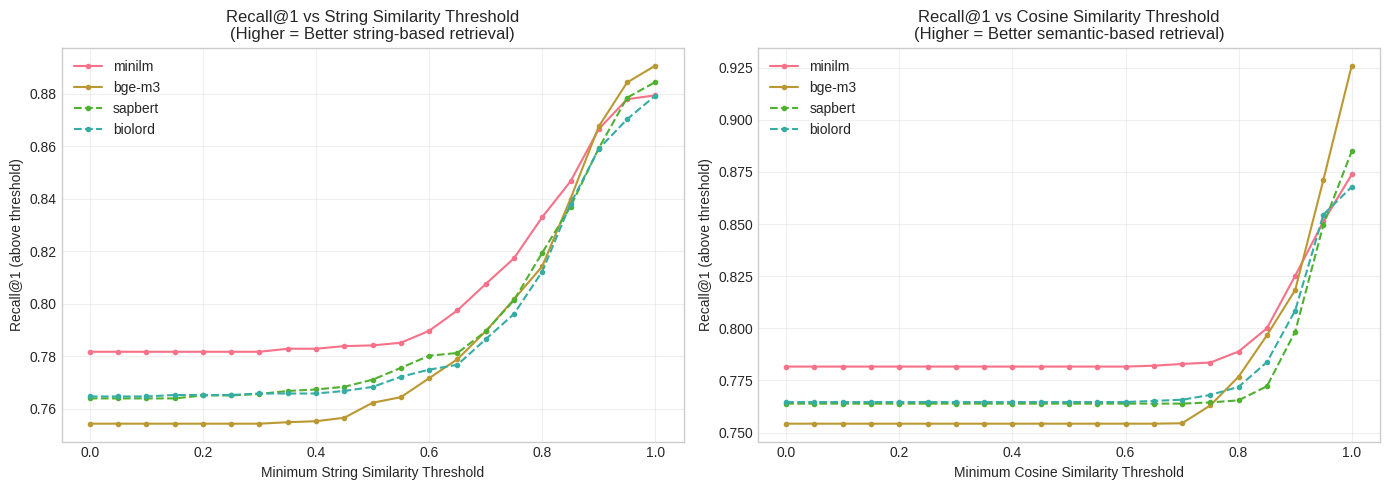

In [20]:
# How does success rate vary with similarity thresholds?
# This shows which similarity measure is more predictive of success

thresholds = np.arange(0, 1.05, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Recall vs string similarity threshold
ax = axes[0]
for model_name in MODELS.keys():
    model_df = rank0_df[rank0_df['model'] == model_name]
    recalls = []
    for t in thresholds:
        above_threshold = model_df[model_df['string_sim'] >= t]
        if len(above_threshold) > 0:
            recall = above_threshold['is_correct'].mean()
        else:
            recall = np.nan
        recalls.append(recall)
    
    linestyle = '--' if MODELS[model_name]['type'] == 'biomedical' else '-'
    ax.plot(thresholds, recalls, label=model_name, linestyle=linestyle, marker='o', markersize=3)

ax.set_xlabel('Minimum String Similarity Threshold')
ax.set_ylabel('Recall@1 (above threshold)')
ax.set_title('Recall@1 vs String Similarity Threshold\n(Higher = Better string-based retrieval)')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Recall vs cosine similarity threshold
ax = axes[1]
for model_name in MODELS.keys():
    model_df = rank0_df[rank0_df['model'] == model_name]
    recalls = []
    for t in thresholds:
        above_threshold = model_df[model_df['cosine_sim'] >= t]
        if len(above_threshold) > 0:
            recall = above_threshold['is_correct'].mean()
        else:
            recall = np.nan
        recalls.append(recall)
    
    linestyle = '--' if MODELS[model_name]['type'] == 'biomedical' else '-'
    ax.plot(thresholds, recalls, label=model_name, linestyle=linestyle, marker='o', markersize=3)

ax.set_xlabel('Minimum Cosine Similarity Threshold')
ax.set_ylabel('Recall@1 (above threshold)')
ax.set_title('Recall@1 vs Cosine Similarity Threshold\n(Higher = Better semantic-based retrieval)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary and Key Findings

Synthesize the analysis into actionable insights.

In [21]:
# Generate comprehensive summary

print("=" * 70)
print("STRING SIMILARITY vs SEMANTIC SIMILARITY: KEY FINDINGS")
print("=" * 70)

# 1. Overall correlation
overall_r, overall_p = stats.pearsonr(rank0_df['string_sim'], rank0_df['cosine_sim'])
print(f"\n1. OVERALL CORRELATION")
print(f"   Pearson r = {overall_r:.3f} (p = {overall_p:.2e})")
if overall_r > 0.5:
    print("   Interpretation: Moderate-strong correlation - cosine partly tracks string similarity")
else:
    print("   Interpretation: Weak correlation - cosine largely independent of string similarity")

# 2. Category patterns
print(f"\n2. CATEGORY PATTERNS")
cat_summary = rank0_df.groupby('category').agg({
    'string_sim': 'mean',
    'cosine_sim': 'mean', 
    'semantic_gap': 'mean'
}).round(3)

highest_gap_cat = cat_summary['semantic_gap'].idxmax()
lowest_gap_cat = cat_summary['semantic_gap'].idxmin()
print(f"   Highest semantic gap: {highest_gap_cat} ({cat_summary.loc[highest_gap_cat, 'semantic_gap']:.3f})")
print(f"   Lowest semantic gap: {lowest_gap_cat} ({cat_summary.loc[lowest_gap_cat, 'semantic_gap']:.3f})")

# 3. Model comparison
print(f"\n3. MODEL COMPARISON (Biomedical vs General)")
model_summary = rank0_df.groupby('model').agg({
    'semantic_gap': 'mean',
    'is_correct': 'mean'
}).round(4)

for model_name in model_summary.index:
    model_type = MODELS[model_name]['type']
    gap = model_summary.loc[model_name, 'semantic_gap']
    recall = model_summary.loc[model_name, 'is_correct']
    print(f"   {model_name} ({model_type}): gap={gap:.4f}, recall@1={recall:.4f}")

# Statistical comparison
bio_gap = rank0_df[rank0_df['model_type'] == 'biomedical']['semantic_gap'].mean()
gen_gap = rank0_df[rank0_df['model_type'] == 'general']['semantic_gap'].mean()
gap_diff = bio_gap - gen_gap
print(f"\n   Biomedical models avg gap: {bio_gap:.4f}")
print(f"   General models avg gap: {gen_gap:.4f}")
print(f"   Difference: {gap_diff:+.4f}")

# 4. Synonym query deep dive
print(f"\n4. SYNONYM QUERIES (Key Semantic Understanding Test)")
syn_summary = rank0_df[rank0_df['category'] == 'synonym_match'].groupby('model').agg({
    'string_sim': 'mean',
    'semantic_gap': 'mean',
    'is_correct': 'mean'
}).round(3)

best_syn_model = syn_summary['is_correct'].idxmax()
print(f"   Mean string similarity (all models): {syn_summary['string_sim'].mean():.3f}")
print(f"   Best model for synonyms: {best_syn_model} (recall@1={syn_summary.loc[best_syn_model, 'is_correct']:.3f})")

# 5. Conclusions
print(f"\n5. CONCLUSIONS")
print("-" * 70)

# Check if domain-specific models show better semantic gaps for synonyms
syn_bio = rank0_df[(rank0_df['category'] == 'synonym_match') & 
                   (rank0_df['model_type'] == 'biomedical')]['semantic_gap'].mean()
syn_gen = rank0_df[(rank0_df['category'] == 'synonym_match') & 
                   (rank0_df['model_type'] == 'general')]['semantic_gap'].mean()

if syn_bio > syn_gen:
    print("   [+] Biomedical models show LARGER semantic gaps for synonym queries")
    print(f"       (bio={syn_bio:.3f} vs gen={syn_gen:.3f})")
    print("       This suggests better understanding of biomedical term equivalence.")
else:
    print("   [-] General models show larger semantic gaps for synonym queries")
    print(f"       (gen={syn_gen:.3f} vs bio={syn_bio:.3f})")
    print("       Domain-specific training may not provide advantage for this task.")

# Check if MiniLM's success is due to string matching
minilm_corr = rank0_df[rank0_df['model'] == 'minilm']['string_sim'].corr(
    rank0_df[rank0_df['model'] == 'minilm']['cosine_sim'])
sapbert_corr = rank0_df[rank0_df['model'] == 'sapbert']['string_sim'].corr(
    rank0_df[rank0_df['model'] == 'sapbert']['cosine_sim'])

print(f"\n   String-Cosine correlation by model:")
print(f"     MiniLM: r={minilm_corr:.3f}")
print(f"     SapBERT: r={sapbert_corr:.3f}")
if minilm_corr > sapbert_corr:
    print("   MiniLM relies MORE on string matching than SapBERT.")
else:
    print("   SapBERT relies MORE on string matching than MiniLM.")

print("\n" + "=" * 70)

STRING SIMILARITY vs SEMANTIC SIMILARITY: KEY FINDINGS

1. OVERALL CORRELATION
   Pearson r = 0.788 (p = 0.00e+00)
   Interpretation: Moderate-strong correlation - cosine partly tracks string similarity

2. CATEGORY PATTERNS
   Highest semantic gap: fuzzy_match (0.053)
   Lowest semantic gap: exact_match (0.000)

3. MODEL COMPARISON (Biomedical vs General)
   bge-m3 (general): gap=0.0063, recall@1=0.7543
   biolord (biomedical): gap=0.0218, recall@1=0.7646
   minilm (general): gap=0.0220, recall@1=0.7816
   sapbert (biomedical): gap=0.0294, recall@1=0.7639

   Biomedical models avg gap: 0.0256
   General models avg gap: 0.0141
   Difference: +0.0115

4. SYNONYM QUERIES (Key Semantic Understanding Test)
   Mean string similarity (all models): 1.000
   Best model for synonyms: bge-m3 (recall@1=0.840)

5. CONCLUSIONS
----------------------------------------------------------------------
   [+] Biomedical models show LARGER semantic gaps for synonym queries
       (bio=0.000 vs gen=-0.000)

In [22]:
# Save analysis dataframe for future reference
# Using CSV as fallback if pyarrow is not installed
output_path_parquet = Path('../results/string_vs_semantic_analysis.parquet')
output_path_csv = Path('../results/string_vs_semantic_analysis.csv')
output_path_parquet.parent.mkdir(parents=True, exist_ok=True)

# Try parquet first, fall back to CSV if pyarrow not available
try:
    analysis_df.to_parquet(output_path_parquet, index=False)
    print(f"Analysis dataframe saved to: {output_path_parquet}")
except ImportError:
    print("PyArrow not available - saving as CSV instead")
    print("(Restart kernel after `uv add pyarrow --optional notebooks` for parquet support)")
    analysis_df.to_csv(output_path_csv, index=False)
    print(f"Analysis dataframe saved to: {output_path_csv}")

print(f"Shape: {analysis_df.shape}")

Analysis dataframe saved to: ../results/string_vs_semantic_analysis.parquet
Shape: (54040, 15)
